In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Cloning into 'dl_basics'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 105 (delta 36), reused 74 (delta 21), pack-reused 0
Receiving objects: 100% (105/105), 1.16 MiB | 2.64 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Found GPU: Tesla T4.


In [2]:
from data_gen.modulo_arithmetic import addition_modulo_data
import models
import utils

/content/dl_basics/models/mlp.py:30: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if act is not "linear":


In [3]:
P = {}

P["addition_modulo_data"] = {
    "p_max" : 113,
    "train_size" : 0.75,
    "add_equal_sign" : True,
    "seed" : 42,
}

x_train, x_val, y_train, y_val = addition_modulo_data(**P["addition_modulo_data"])
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(9576, 3) (3193, 3) (9576,) (3193,)


In [4]:
# init new run

'''
P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 256,
    "num_outputs" : P["addition_modulo_data"]["p_max"],
    "input_shape" : (2,),
    "num_hidden_gru" : 3,
    "use_embedding" : True,
    "vocab_size" : P["addition_modulo_data"]["p_max"],
    "embedding_dim" : 256,
    "return_final_hidden" : True,
}
'''

P["model_name"] = "transformer_01"
P["model_build_params"] = {
    "input_shape" : (3,),
    "num_heads" : 4,
    "num_tokens" : P["addition_modulo_data"]["p_max"] + 1, # + 1 for the "=" sign
    "embedding_dim" : 128,
    "return_final_token_only" : True,
}

model = eval("models." + P["model_name"])(**P["model_build_params"])

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = [ "accuracy" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
print("Run dir :", P["run_dir"])

run = utils.TrainingRun()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 3)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 3, 128)       14592       ['input[0][0]']                  
                                                                                                  
 multi_head_attention (MultiHea  (None, 3, 128)      66048       ['embedding[0][0]',              
 dAttention)                                                      'embedding[0][0]']              
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 3, 128)      0           ['multi_head_attention[0][0]'

In [9]:
NUM_EPOCHS = 1024*4
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    x_train, y_train,
    epochs = NUM_EPOCHS,
    batch_size = len(x_train),
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

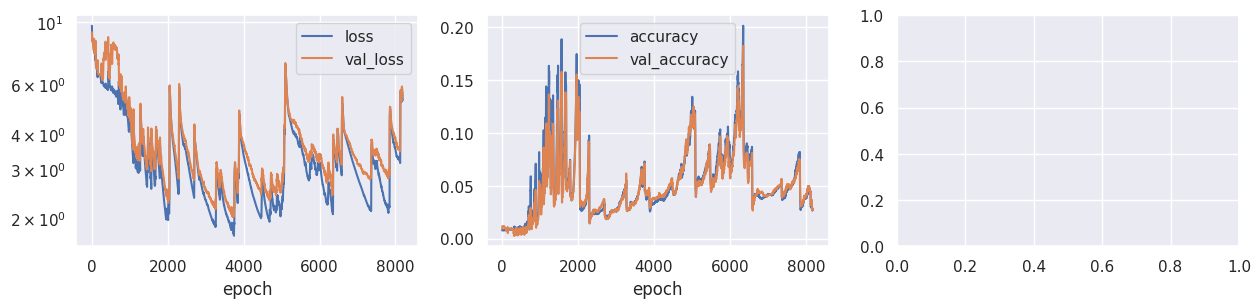

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);
#axs[1].set_ylim(0,0.2);

#sns.lineplot(data=run.history[["lr"]], ax=axs[2], dashes=False);

In [ ]:
model.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics = [ "mae" ]
)

In [ ]:
run.save_state(os.path.join(OUTPUT_DIR, P["run_dir"]), P, model)

In [ ]:
#P, model = run.load_state("../output/gru_01-230407-220913")

In [ ]:
y_pred = model.predict(x)

1/1 [==============================] - 1s 1s/step


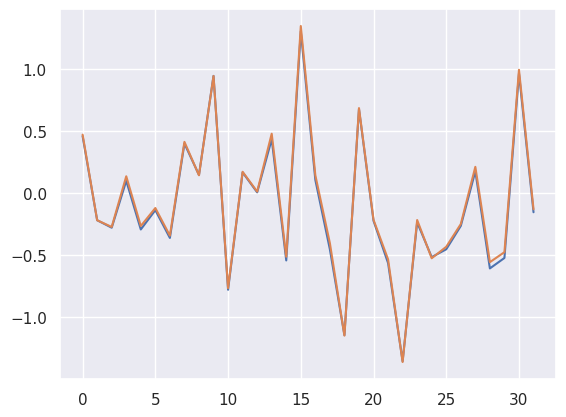

In [ ]:
plt.plot(y_pred)
plt.plot(y)